 `Value` holds a single variable $x$  (a floating point), keeps track of the _gradient_  $\tfrac{\partial f}{\partial x}$ wrt $f$ that depends on $x$ and other variables.

We don't know $f$ in advance. Build $f$ by applying operations to $x$, and use the `backward' operation to compute the derivatives $\tfrac{\partial f}{\partial u}$ wrt all the intermediate values $u$ that $f$ depends on.


If we run
```
a = Value(5)
def f(x): return (x+2)**2 + x**3
y = f(a)
y.backward()
print(y.data, a.grad)
```

We get `174, 89`  ince 
$(5+2)^2 + 5^3 = 174$ and the derivative of $(x+2)^2 + x^3 = x^2 + 4x + 4 + x^3$ equals  $3x^2 + 2x + 4$

In [103]:

class Value:
    
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)
        self.grad = 0  # ignore for now
        self._backward = lambda: None # ignore for now
    
    def __repr__(self): return f"Value({self.data},{self._prev if self._prev else '{}'})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other))
        return out
   
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other))
        return out     

In [104]:
a = Value(5)
b= Value(7)
c = a+b
c

Value(12,{Value(5,{}), Value(7,{})})

In [105]:
c * 3

Value(36,{Value(3,{}), Value(12,{Value(5,{}), Value(7,{})})})

We now add computing gradient. If $c = a + b$ then it contributes $\tfrac{\partial z}{\partial c}$ to both $\tfrac{\partial z}{\partial a}$ and  $\tfrac{\partial z}{\partial b}$

If $c = a\cdot b$ then it contributes $\tfrac{\partial z}{\partial c}b$ to  $\tfrac{\partial z}{\partial a}$ and $\tfrac{\partial z}{\partial c}a$ to $\tfrac{\partial z}{\partial b}$.

In [ ]:
def bind(cls, *funcs):
    for func in funcs:
        setattr(cls, func.__name__, func)


In [106]:
def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other))

    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward

    return out

def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other))

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out

def __pow__(self,n):
    out = Value(1)
    for i in range(n):
        out = self*out
    return out

bind(Value,__add__,__mul__,__pow__)

In [107]:
a = Value(5)
b = Value(7)
c = a*b
c

Value(35,{Value(7,{}), Value(5,{})})

In [108]:
c.grad = 1
c._backward()
a.grad, b.grad

(7, 5)

In [ ]:
def backward(self, visited= None): 
    print(len(visited) if visited else 0)
    if visited is None:
        visited= set([self])
        self.grad = 1
    self._backward()
    for child in self._prev:
        if not child in visited:
            visited.add(child)
            child.backward(visited)
bind(Value,backward)

In [ ]:
a = Value(5)
def f(x): return (x+2)**2 + x**3
y = f(a)
y.backward()
print(y.data, a.grad)

In [ ]:
b.backward()
a.grad , 6*a.data**2

We now add to `Value` the recursive `backwards` and the various arithmetic operations.

In [109]:
import random

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data = None, _children=(), _op=''):
        if data is None: data = random.uniform(-1,1)
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def backward(self, visited= None): # slightly shorter code to fit in the blog
        if visited is None:
            visited= set([self])
            self.grad = 1
        self._backward()
        for child in self._prev:
            if not child in visited:
                visited.add(child)
                child.backward(visited)

    # Arithmetic operations

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
# In first reading you can ignore all code below here - if you understand everything above then you undestand the main concepts
##############################################################################################################################

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    # Other operations implemented in terms of prior ones
    def __float__(self): return float(self.data)
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other):  return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1
    def __repr__(self): return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
import random

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data = None, _children=(), _op=''):
        if data is None:
          data = random.uniform(-1,1)
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


    # Arithmetic operations

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
# In first reading you can ignore all code below here - if you understand everything above then you undestand the main concepts
##############################################################################################################################

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    # Other operations implemented in terms of prior ones
    def __float__(self): return float(self.data)
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other):  return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1
    def __repr__(self): return f"Value(data={self.data}, grad={self.grad})"

Let's check that we get what we intended to get

In [114]:
a = Value(2)
def f(x): return 5*(x**2+2)
y = f(a)
y.backward()
print(a.grad, y, y._prev)

20 Value(data=30, grad=1) {Value(data=5, grad=6), Value(data=6, grad=5)}


In [ ]:
u = Value(5)
v = u**3
w= u+u
z = v*w
print(f"u={u.data},v={v.data},w={w.data},z={z.data}")

In [ ]:
z.backward()
print(f"Gradients: u={u.grad},v={v.grad},w={w.grad},z={z.grad}")

## Stochastic gradient descent

`Linear` class  has two weights $a$ and $b$, and such that if $f$ is a `Linear` object then $f(x)=a\cdot x+ b+\cdot x$.

Fit a line to data $\{ (x_i,y_i) \}$ by defining a linear model $f$, computing using backpropagation the gradient $\nabla = \nabla \sum_i (f(x_i)-y_i)^2$ and then updating $(a,b) \leftarrow (a,b) - \eta \nabla$.

In [115]:
class Linear:
    def __init__(self):
        self.a,self.b = Value(random.random()),Value(random.random())
    def __call__(self,x): return self.a*x+self.b
    def zero_grad(self):
        self.a.grad, self.b.grad = 0,0

def loss(y,y_): return (y-y_)**2

In [ ]:
# Plotting functions - feel free to skip this cell
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
import random
import numpy as np


# Helper function to plot datapoints and function approximators
def plot(X,Y,f=None,pt_legend='',line_legend='',title='', ylim=None):
    fig, ax = plt.subplots(figsize=(8,8))
    ln = None
    if Y:
        ln= ax.scatter(X,Y, color='blue', label=pt_legend)
    if f:
        ln = ax.plot(X,[f(x) for x in X], color='red', label=line_legend)[0]
    if pt_legend or line_legend:
        ax.legend()
    if ylim:
        ax.set_ylim(*ylim)
    return fig,ax,ln


# Utility code to animate SGD
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
Ys = []
X = []
model = None
fig, ax, ln = None, None, None
fig = None;

def updateY():
    Ys.append([float(model(x)) for x in X])

def initY():
    global Ys
    Ys = []
    updateY()

def animate(gif="", skips = 1):
    def update(frame):
        ln.set_data(X, Ys[frame])
        return ln,

    ani = FuncAnimation(fig, update, init_func = lambda: [ln], frames=range(0,len(Ys),skips), blit=True)
    if gif:
      ani.save(gif, fps=15) #writer='imagemagick', fps=15)
    return HTML(ani.to_jshtml())

In [ ]:
!apt install imagemagick
from IPython.display import clear_output
clear_output() #remove this line if you need to debug installation issues

## Fitting a linear model to data

We generate the "ground truth" $a_{gt},b_{gt}$ at random in $[0,5]$ and generate $20$ samples of the form $x_i,y_i$ where $x_i$ is random in $[0,1]$ and $y_i = a_{gt}x_i + b_{gt} + \xi_i$ for noise $\xi_i$ random in $[0,1/2]$.

Ground truth: 3.09, 4.37


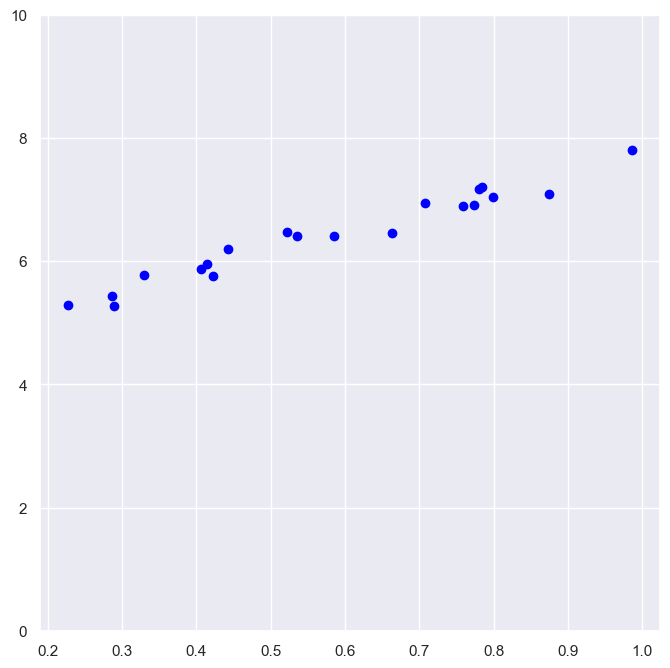

In [117]:
n = 20
a_gt , b_gt = 5*random.random(), 5*random.random()
X = [random.random() for i in range(20)]
Y = [a_gt*x + b_gt + 0.5*random.random() for x in X]
print(f"Ground truth: {a_gt:.2f}, {b_gt:.2f}")
fig, ax, ln = plot(X,Y, ylim=(0,10));

## Training loop:
For a random sample $(x,y)$, we compute the gradient $\nabla = \nabla (f(x)-y)^2$ (which is a vector in $\mathbb{R}^2$) and update $(a,b) \leftarrow (a,b) - \eta \cdot \nabla$

Initial params: 0.72, 0.40
Final params: 3.24, 4.54


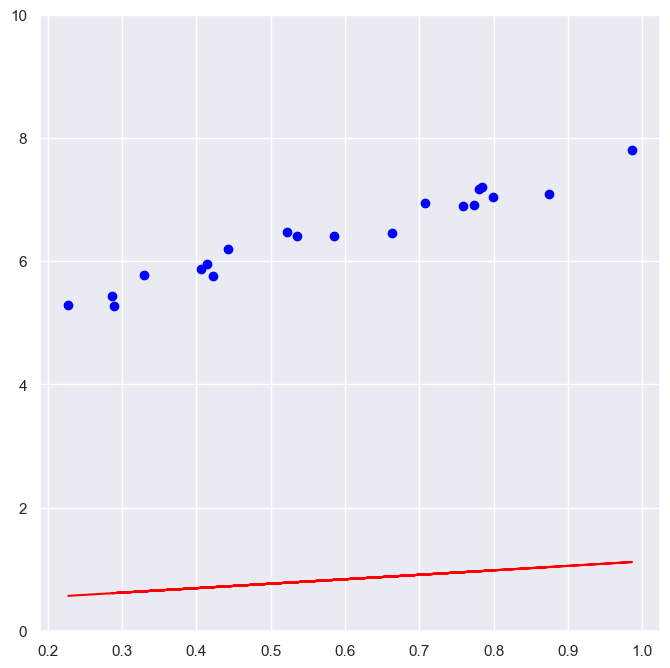

In [118]:
model = Linear()
fig, ax, ln = plot(X,Y, model, ylim=(0,10));
print(f"Initial params: {float(model.a):.2f}, {float(model.b):.2f}")
η = 0.03
epochs = 20
initY()
for t in range(epochs):
    for x,y in zip(X,Y):
        model.zero_grad()
        loss = (model(x)-y)**2
        loss.backward()
        model.a , model.b = (model.a - η*model.a.grad  , model.b - η*model.b.grad)
        updateY()
print(f"Final params: {float(model.a):.2f}, {float(model.b):.2f}")

In [119]:
animate("regression.gif",10)

MovieWriter ffmpeg unavailable; using Pillow instead.


## Neural networks

We now follow Karpathy and do the same for a more sophisticated Neural network - a depth 3 fully connected neural net with two inputs and one outputs, and two hidden layers, each with $16$ neurons.

We will use this to fit the [two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)

This part is based on [Karpathy's demo notebook](https://github.com/karpathy/micrograd/blob/master/demo.ipynb)



In [ ]:
from sklearn.datasets import make_moons, make_blobs
X, Y = make_moons(n_samples=100, noise=0.1)

Y = Y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet');

The Neural network is obtained as follows:

We define the `neuron` function to be a map that takes weights $w$ and inputs $x$ (both vectors in $\mathbb{R}^n$ for some $n$) and returns either $\sum x_iw_i$ or $ReLU(\sum x_iw_i) = \max \{ \sum x_i w_i, 0 \}$ depending on whether the optional parameter `relu` is `True`.

The neural network `Net` has a weight pair $w_{i,j}$ for each pair of units $i,j$ in adjacent layers. It is obtained by applying the `neuron` function in each layer to the corresponding weights and the activations of the previous layer.

In [ ]:
def neuron(weights,inputs, relu =True):
  """A single neuron computing either a linear function of inputs or a ReLU applied to linear function"""
  v =  sum(weights[i]*x for i,x in enumerate(inputs))
  return v.relu() if relu else v


class Net:
  """Depth 3 fully connected neural net with one two inputs and output"""

  def __init__(self,  N=16):
    self.layer_1 = [[Value(),Value()] for i in range(N)]
    self.layer_2 = [ [Value() for j in range(N)] for i in range(N)]
    self.output =  [ Value() for i in range(N)]
    self.parameters = [v for L in [self.layer_1,self.layer_2,[self.output]] for w in L for v in w]


  def __call__(self,x):
    layer_1_vals = [neuron(w,x) for w in self.layer_1]
    layer_2_vals = [neuron(w,layer_1_vals) for w in self.layer_2]
    return neuron(self.output,layer_2_vals,relu=False)

  def zero_grad(self):
    for p in self.parameters:
      p.grad=0





In [ ]:
model = Net()


In [ ]:
model = Net()
epochs = 10

η = 0.05
for t in range(epochs):
    loss = sum([(1+ -y*model(x)).relu() for (x,y) in zip(X,Y)])/len(X)
    model.zero_grad()
    loss.backward()
    for p in model.parameters:
        p.data -= η*p.grad
    acc = sum(float(model(x))*y>0 for (x,y) in zip (X,Y))
    print(f"Epoch {t} mean loss {loss.data} Accuracy {acc*100 / len(X):.0f}%")


Let's plot the decision boundary

In [ ]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

For a more optimized construction ands optimization, see [Karpathy's demo notebook](https://github.com/karpathy/micrograd/blob/master/demo.ipynb)

### Animation of NN evolution

(This is slow and somewhat buggy)

In [92]:
# Add bias
class Neuron:

  def __init__(self,params,in_dim, relu=True):
    self.relu = relu
    self.weights = [Value() for i in range(in_dim)]
    self.bias = Value(0)
    self.parameters = self.weights + [self.bias]
    params.extend(self.parameters)


  def __call__(self,X):
    v =  sum(self.weights[i]*x for i,x in enumerate(X))+self.bias
    return v.relu() if self.relu else v


class Net:
  """Depth 3 fully connected neural net with one two inputs and output"""

  def __init__(self,  N=16):
    self.N = N
    self.parameters = []
    self.layer1 = [Neuron(self.parameters,2) for i in range(N)]
    self.layer2 = [ Neuron(self.parameters,N) for j in range(N)]
    self.output =  Neuron(self.parameters,N,relu=False)



  def __call__(self,x):
    layer1_vals = [n(x) for n in self.layer1]
    layer2_vals = [n(layer1_vals) for n in self.layer2]
    return self.output(layer2_vals)

  def zero_grad(self):
    for p in self.parameters:
      p.grad=0





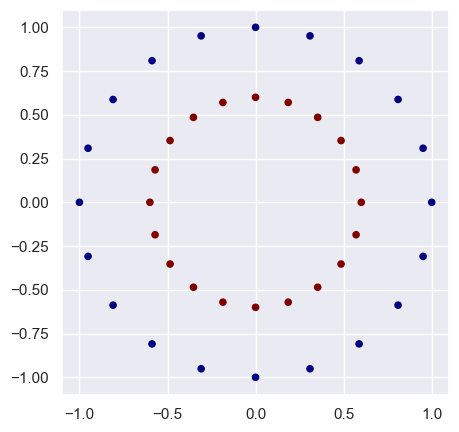

In [93]:
from sklearn.datasets import make_moons, make_circles
X, Y = make_circles(n_samples=40, factor = 0.6)


Y = 2*(Y % 2) - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet');

In [94]:
def copy(model):
  net = Net(model.N)
  for i,p in enumerate(model.parameters):
    net.parameters[i].data = p.data
  return net

In [95]:
def Zvals(model):
  global X
  h = 0.25
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  inputs = [list(map(Value, xrow)) for xrow in Xmesh]
  scores = list(map(model, inputs))
  Z = np.array([s.data > 0 for s in scores])
  Z = Z.reshape(xx.shape)
  return Z


def dboundary(model):
  global X
  global Y
  h = 0.25
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  fig, ax = plt.subplots(figsize=(8,8))
  Z = Zvals(model)
  ln = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  return  fig,ax,ln

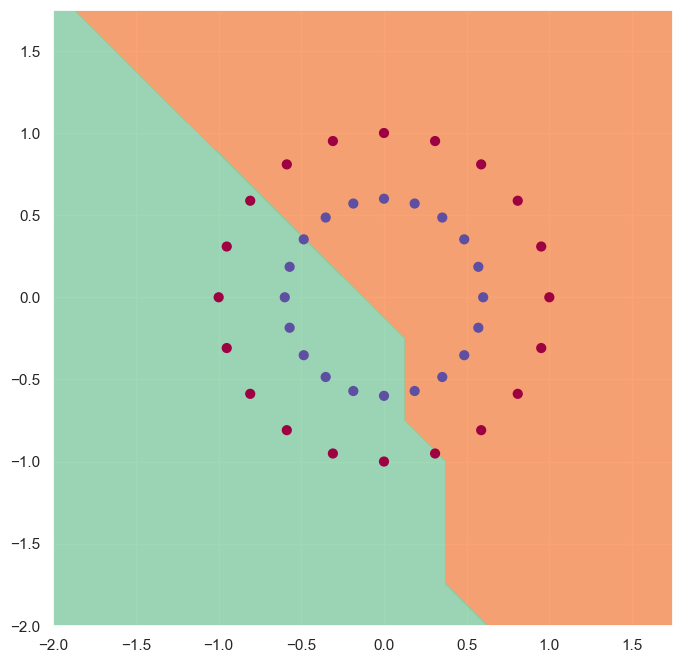

In [96]:
model = Net()
models = [model]
fig,ax,ln = dboundary(model)


In [98]:
epochs = 15
η = 0.1
for t in range(epochs):
  loss = sum([(1+ -y*model(x)).relu() for (x,y) in zip(X,Y)])/len(X)
  model.zero_grad()
  loss.backward()
  for p in model.parameters:
    p.data -= η*p.grad
  models.append(copy(model))
  acc = sum(float(model(x))*y>0 for (x,y) in zip (X,Y))
  print(f"Epoch {t} mean loss {loss.data} Accuracy {acc*100 / len(X):.0f}%")


Epoch 0 mean loss 0.5402505928921456 Accuracy 85%
Epoch 1 mean loss 0.4417366029412668 Accuracy 92%
Epoch 2 mean loss 0.3647870211846644 Accuracy 98%
Epoch 3 mean loss 0.29791794478915334 Accuracy 100%
Epoch 4 mean loss 0.2511079065779781 Accuracy 100%
Epoch 5 mean loss 0.21737339906433123 Accuracy 100%
Epoch 6 mean loss 0.18889978064131657 Accuracy 100%
Epoch 7 mean loss 0.17139451429471697 Accuracy 100%
Epoch 8 mean loss 0.15867844867062264 Accuracy 100%
Epoch 9 mean loss 0.14488907408870158 Accuracy 100%
Epoch 10 mean loss 0.13443508069301666 Accuracy 100%
Epoch 11 mean loss 0.12196257725317011 Accuracy 100%
Epoch 12 mean loss 0.11275291416072353 Accuracy 100%
Epoch 13 mean loss 0.10187194718168813 Accuracy 100%
Epoch 14 mean loss 0.09291326499405106 Accuracy 100%


In [99]:
len(models)

31

Animating model 0
Animating model 1
Animating model 2
Animating model 3
Animating model 4
Animating model 5
Animating model 6
Animating model 7
Animating model 8
Animating model 9
Animating model 10
Animating model 11
Animating model 12
Animating model 13
Animating model 14
Animating model 15
Animating model 16
Animating model 17
Animating model 18
Animating model 19
Animating model 20
Animating model 21
Animating model 22
Animating model 23
Animating model 24
Animating model 25
Animating model 26
Animating model 27
Animating model 28
Animating model 29
Animating model 30


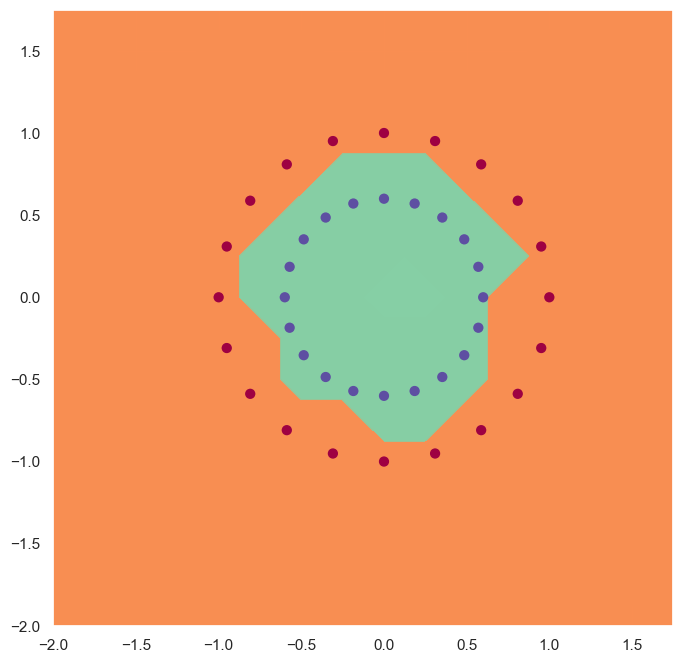

In [100]:
fig, ax = plt.subplots(figsize=(8,8))

artists = []
for i,model in enumerate(models):
  print(f"Animating model {i}")
  h = 0.25
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  Z = Zvals(model)
  cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  scat = ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  artists.append(cs.collections + [scat])

#plt.show()

In [101]:
import matplotlib.animation as animation
ani = animation.ArtistAnimation(fig, artists, interval=1000, blit=True,
                                repeat_delay=2000)

In [102]:
HTML(ani.to_jshtml())